Plan
1. Read data (train and test).
2. Process data:

   2.1. Keep "feature_1" records with "A" values.

   2.2. Impute missing values.
   
   2.3. Convert target string values to integers.

3. Run Feature Engineering.
5. Run FS.
6. Apply train-validation split.
7. Run GridsearchCV parameter tuning with RF.
8. Preprocess test data (imputation, FEng etc.).
9. Make prediction:

   9.1. Predict "Low" if "feature_1" not "A".
   
   9.2. Use ML to predict the rest.

   9.3. Concatenate datasets.

In [1]:
import dvclive
import joblib
import numpy as np
import logging
from matplotlib import pyplot as plt
import pandas as pd 
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Specify attributes - https://docs.python.org/3/library/logging.html#logging.LogRecord
logging.basicConfig(filename='../logs/experiments.log',
                    level=logging.DEBUG,
                    format='%(levelname)s: %(asctime)s %(message)s') #Can optionally add %(processName)s 

# Adding a StreamHandler to also log to console
# console_handler = logging.StreamHandler()
# console_handler.setFormatter(logging.Formatter('%(levelname)s: %(asctime)s %(message)s'))
# logging.getLogger().addHandler(console_handler)

### 1. Read data

In [2]:
df = pd.read_csv('../data/train.csv', parse_dates=['job_posted_date'])
df_test = pd.read_csv('../data/test.csv', parse_dates=['job_posted_date'])

C:\Users\yurii\AppData\Local\Temp\ipykernel_19596\1530981748.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/train.csv', parse_dates=['job_posted_date'])
C:\Users\yurii\AppData\Local\Temp\ipykernel_19596\1530981748.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test = pd.read_csv('../data/test.csv', parse_dates=['job_posted_date'])


### 2. Preprocess
2.1. Keep only records with "feature_1" equals "A".

In [3]:
df = df.query('feature_1 == "A"').reset_index(drop=True)

In [4]:
df = df.drop(columns=['obs', 'job_posted_date', 'feature_1'])
df.head(2)

,job_title,salary_category,job_state,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,Others,High,NY,0.6429,False,False,True,True,True,False,...,-0.362079,-0.499308,-0.367894,-0.214881,0.014870,-0.271177,-0.113347,-0.587955,-0.919095,-0.207340
1,Job_Title_1,Low,CA,0.4678,False,False,False,True,True,True,...,-0.300989,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364


### 2.2. Impute missing values

In [5]:
[col for col in df.columns if df[col].isnull().sum() > 0]

['job_state', 'feature_10']

<AxesSubplot:>

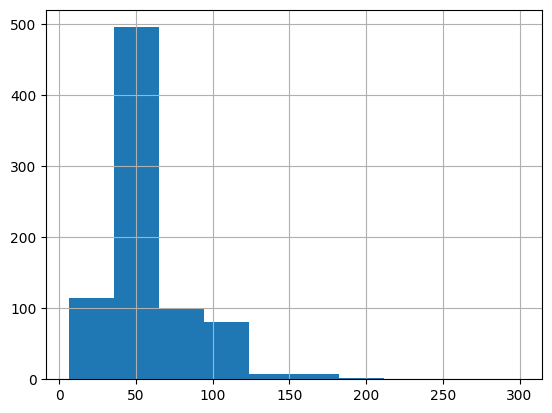

In [6]:
df['feature_10'].hist()

In [14]:
df['job_state'] = df['job_state'].fillna(df['job_state'].mode()[0])
df['feature_10'] = df['feature_10'].fillna(df['feature_10'].median())

### 2.3. Turn string target to integer

In [17]:
df['salary_category_num'] = df['salary_category'].map({'High': 2, 'Medium': 1, 'Low':0})
df.drop(columns=['salary_category'], inplace=True)

### 3. Run Feature Engineering
- Target encode categorical columns.
- Turn Boolean column values to integers.

In [18]:
df.head(2)

,job_title,job_state,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300,salary_category_num
0,Others,NY,0.6429,False,False,True,True,True,False,False,...,-0.499308,-0.367894,-0.214881,0.014870,-0.271177,-0.113347,-0.587955,-0.919095,-0.207340,2
1,Job_Title_1,CA,0.4678,False,False,False,True,True,True,False,...,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364,0


In [19]:
df_stats = df.groupby('job_title').agg({'salary_category_num': 'mean'}).reset_index()
mapping_jobtitle = df_stats.set_index('job_title')['salary_category_num'].to_dict()
df['job_title'] = df['job_title'].map(mapping_jobtitle)

In [20]:
df_stats_state = df.groupby('job_state').agg({'salary_category_num': 'mean'}).reset_index()
mapping_jobstate = df_stats_state.set_index('job_state')['salary_category_num'].to_dict()
df['job_state'] = df['job_state'].map(mapping_jobstate)

In [21]:
for col in [col for col in df.columns if df[col].dtype == 'bool']:
    df[col] = df[col].map({True: 1, False: 0})

In [22]:
df.head()

,job_title,job_state,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300,salary_category_num
0,1.037296,1.211740,0.6429,0,0,1,1,1,0,0,...,-0.499308,-0.367894,-0.214881,0.014870,-0.271177,-0.113347,-0.587955,-0.919095,-0.207340,2
1,1.000000,1.033392,0.4678,0,0,0,1,1,1,0,...,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364,0
2,1.037296,1.033392,0.4610,0,0,0,1,1,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,1.037296,1.033392,0.5064,0,0,0,1,1,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,1.037296,1.033392,0.4640,0,0,0,1,1,0,0,...,-0.654657,-0.074398,-0.464479,0.081037,-0.136992,-0.276270,-0.696853,-0.601466,0.089939,0


### 4. Run Feature Selection 

In [23]:
X = df.drop(columns=['salary_category_num'])
y = df['salary_category_num']

In [60]:
X_fs = X.copy(deep=True)
scaler = MinMaxScaler()
X_fs = scaler.fit_transform(X_fs)

In [63]:
selector = SelectKBest(score_func=chi2, k=10)
feature_names = X.columns
#fit = selector.fit(X_fs, y)
X_new = selector.fit_transform(X_fs, y)

# Get selected feature names
selected_features = feature_names[selector.get_support()]

selected_features

Index(['feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_8',
       'feature_9', 'feature_12', 'job_desc_012', 'job_desc_021',
       'job_desc_299'],
      dtype='object')

In [146]:
df

,job_title,job_state,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300,salary_category_num
0,1.037296,1.211740,0.6429,0,0,1,1,1,0,0,...,-0.499308,-0.367894,-0.214881,0.014870,-0.271177,-0.113347,-0.587955,-0.919095,-0.207340,2
1,1.000000,1.033392,0.4678,0,0,0,1,1,1,0,...,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364,0
2,1.037296,1.033392,0.4610,0,0,0,1,1,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,1.037296,1.033392,0.5064,0,0,0,1,1,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,1.037296,1.033392,0.4640,0,0,0,1,1,0,0,...,-0.654657,-0.074398,-0.464479,0.081037,-0.136992,-0.276270,-0.696853,-0.601466,0.089939,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,2.000000,1.033392,0.5391,0,0,0,1,0,0,0,...,-0.471856,0.002497,0.245694,0.251105,0.119141,-0.184764,-0.482634,-0.819574,-0.241306,2
1228,1.037296,1.033392,0.7151,1,0,0,1,1,0,0,...,-0.796785,0.154025,-0.462344,-0.053803,-0.297083,-0.277624,-0.924568,-0.897608,-0.236864,2
1229,0.700000,1.211740,0.5791,0,0,0,1,0,0,0,...,-0.329539,-0.429462,-0.141221,0.119336,-0.483549,-0.146601,-0.715821,-0.739832,-0.128655,1
1230,1.218750,1.033392,0.7082,0,0,0,1,0,0,0,...,-0.242665,-0.311564,-0.032751,-0.301447,-0.480434,-0.112401,-0.828844,-1.066424,-0.228583,1


In [150]:
df_output = df[selected_features]
df_output['salary_category'] = y
df_output['salary_category'] = df_output['salary_category'].map({0: 'Low', 1: 'Medium', 2: 'High'})
df_output.to_csv(f'../data/processed/{run_timestamp}_training_data.csv', index=False)

C:\Users\yurii\AppData\Local\Temp\ipykernel_19596\3790984164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['salary_category'] = y
C:\Users\yurii\AppData\Local\Temp\ipykernel_19596\3790984164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['salary_category'] = df_output['salary_category'].map({0: 'Low', 1: 'Medium', 2: 'High'})


### 6. Run GridSearch CV with Random Forest

In [79]:
run_timestamp = pd.to_datetime('now').strftime('%Y%m%d_%H-%M-%S')
rf = RandomForestClassifier(random_state=1)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 60, 70, 100, 120, 150],        # Number of trees
    'max_depth': [None, 3,4, 5, 10],           # Depth of trees
    'min_samples_split': [2, 5, 10],       # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples at a leaf node
}

In [81]:
# Perform GridSearchCV
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, 
                                 cv=5, n_jobs=-1, verbose=2, scoring='accuracy', random_state=1)

grid_search.fit(X[selected_features], y)

# Best parameters and model evaluation
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None}


In [92]:
joblib.dump(best_rf, f'../models/{run_timestamp}_rf_model.joblib')
pd.DataFrame(grid_search.cv_results_).to_csv(f'../cv_results/{run_timestamp}_rf_model_results.csv', index=False)

logging.info(f"Best Parameters: {grid_search.best_params_}")
logging.info(f"Model saved to: ../models/{run_timestamp}_rf_model.joblib")
logging.info(f"CV results saved to: ../cv_results/{run_timestamp}_rf_model_results.csv")
logging.info(f"Selected features:{run_timestamp} selected features- {selected_features}")

### 7. Preprocess test data

In [100]:
['obs']+list(selected_features)

['obs',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_8',
 'feature_9',
 'feature_12',
 'job_desc_012',
 'job_desc_021',
 'job_desc_299']

In [151]:
df_test[selected_features].to_csv(f'../data/processed/{run_timestamp}_testing_data.csv', index=False)

In [103]:
df_test_rule = df_test.query('feature_1 != "A"')[['obs']+list(selected_features)].reset_index(drop=True)
df_test_ml = df_test.query('feature_1 == "A"')[['obs']+list(selected_features)].reset_index(drop=True)

In [105]:
df_test_rule['salary_category'] = 'Low'

In [107]:
df_test_ml.head(2)

,obs,feature_2,feature_3,feature_4,feature_5,feature_8,feature_9,feature_12,job_desc_012,job_desc_021,job_desc_299
0,1281,0.6473,False,False,True,False,False,False,-0.581684,3.536066,-0.702116
1,1282,0.4238,True,False,False,False,False,False,-0.758666,3.380567,-0.505897


In [108]:
for col in [col for col in df_test_ml.columns if df_test_ml[col].dtype == 'bool']:
    df_test_ml[col] = df_test_ml[col].map({True: 1, False: 0})

In [111]:
run_timestamp = '20250401_15-59-39'
model = joblib.load(f'../models/{run_timestamp}_rf_model.joblib')
prediction = model.predict(df_test_ml[selected_features])

In [119]:
df_test_ml['salary_category'] = prediction
df_test_ml['salary_category'] = df_test_ml['salary_category'].map({0: 'Low', 1: 'Medium', 2: 'High'})

In [136]:
df_results = pd.concat([df_test_rule, df_test_ml], axis=0).reset_index(drop=True)
df_results = df_results[['obs', 'salary_category']].reset_index(drop=True)


In [137]:
df_results['salary_category'].value_counts(normalize=True)#.plot(kind='bar', color=['blue', 'orange', 'green'])

salary_category
High      0.459016
Low       0.297424
Medium    0.243560
Name: proportion, dtype: float64

In [138]:
df_results.sort_values(by='obs', ascending=True, inplace=True)
df_results = df_results.reset_index(drop=True)

In [140]:
df_results.to_csv(f"../results/{run_timestamp}_rf_model_results.csv", index=False)